In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facialemotion/icml_face_data.csv
/kaggle/input/facialemotion/example_submission.csv
/kaggle/input/facialemotion/train.csv
/kaggle/input/facialemotion/test.csv
/kaggle/input/facialemotion/fer2013/fer2013/README
/kaggle/input/facialemotion/fer2013/fer2013/fer2013.bib
/kaggle/input/facialemotion/fer2013/fer2013/fer2013.csv


In [2]:
import torch
import torchvision
import torchvision.transforms as transform
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm_notebook
import torch.nn.functional as F
import collections
import time
import torch.onnx
import copy
from skimage import io
import seaborn as sns
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [3]:
train_set = pd.read_csv('/kaggle/input/facialemotion/train.csv')
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

<AxesSubplot:xlabel='emotion', ylabel='count'>

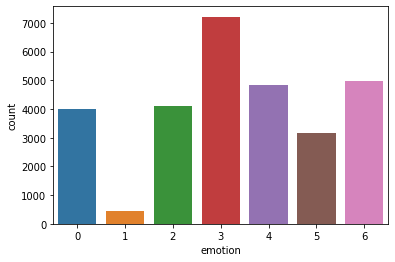

In [4]:
sns.countplot(x="emotion",data=train_set)


In [5]:
train_set

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [6]:
oversample = RandomOverSampler(sampling_strategy='auto')
 #fit and apply the transform
X_over, y_over = oversample.fit_resample((train_set.pixels).values.reshape(-1, 1), train_set.emotion)


a = np.array(y_over)
collections.Counter(a)
X_over.shape

(50505, 1)

In [7]:
X_train,X_val,Y_train,Y_val = train_test_split(train_set['pixels'],train_set['emotion'],test_size=0.2,random_state=42,stratify=train_set['emotion'])
X_train,X_val,Y_train,Y_val = X_train.values.reshape(-1,1),X_val.values.reshape(-1,1),Y_train,Y_val
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(22967, 1) (5742, 1) (22967,) (5742,)


In [8]:
class EmotionDataset(Dataset):
    def __init__(self,X,Y,transform):
        self.x = X
        self.y = Y
        self.transform = transform
    
    def __getitem__(self,idx):
        image = np.fromstring(self.x[idx][0],dtype='float32',sep=' ').reshape(48,48)
        label = self.y.iloc[idx]
    
        if(self.transform):
            image = self.transform(image)
        return (image,label)
    
    def __len__(self):
        return len(self.y.index)

In [9]:
train_transform = transform.Compose([
                                    transform.ToTensor(),
                                    transform.Normalize((0.5),(0.5))
])

val_transform = transform.Compose([       
                                   transform.ToTensor(),
                                   transform.Normalize((0.5),(0.5))

                                      
])

In [10]:
train_dataset = EmotionDataset(X_train,Y_train,train_transform)
val_dataset = EmotionDataset(X_val,Y_val,val_transform)
len(train_dataset)

22967

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=True)

In [12]:
def displayImages(images,labels):
  plt.figure(figsize=(10,20))
  plt.imshow(images[:,:,0])
  plt.xticks([])
  plt.yticks([])
  print(labels)
  plt.show()

torch.Size([64, 1, 48, 48])
Train Image
tensor([3, 5, 2, 0, 0, 0, 6, 5, 3, 4, 4, 0, 6, 6, 3, 6, 4, 5, 4, 3, 2, 1, 4, 6,
        6, 0, 3, 2, 2, 5, 2, 4, 2, 4, 1, 3, 3, 0, 0, 5, 6, 6, 6, 0, 2, 0, 5, 3,
        3, 5, 4, 6, 6, 6, 5, 3, 4, 0, 2, 2, 4, 3, 3, 4])


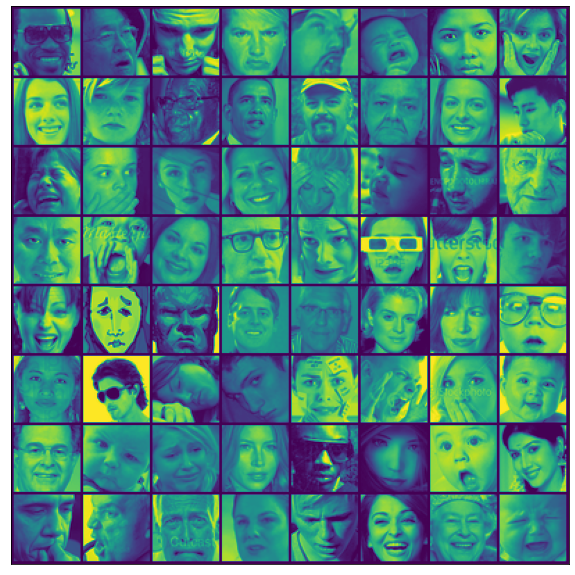

Test Image
tensor([2, 5, 2, 3, 2, 5, 0, 5, 0, 3, 4, 3, 5, 4, 0, 3, 3, 2, 0, 4, 6, 4, 5, 6,
        5, 0, 3, 3, 4, 2, 4, 4, 4, 0, 0, 6, 4, 3, 0, 4, 0, 3, 3, 3, 6, 3, 4, 1,
        0, 2, 0, 2, 3, 0, 6, 4, 3, 2, 5, 6, 5, 3, 4, 2])


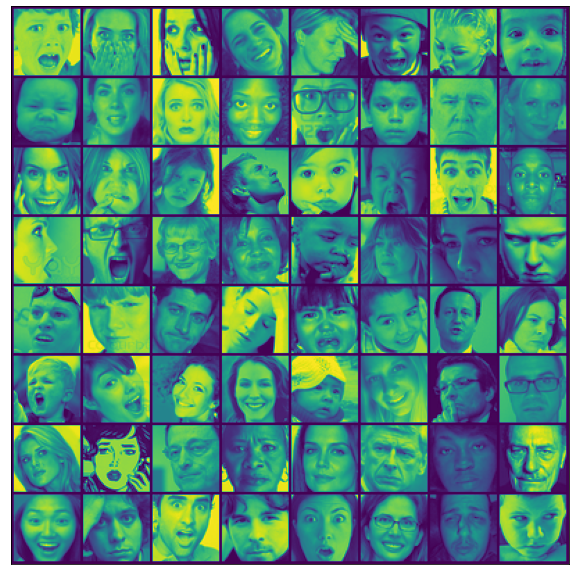

In [13]:
images,labels = next(iter(train_loader))
print(images.shape)
image_grid = torchvision.utils.make_grid(images).permute(1,2,0)
val_images,val_labels = next(iter(validation_loader))
val_image_grid = torchvision.utils.make_grid(val_images).permute(1,2,0)
print("Train Image")
displayImages(image_grid,labels)
print("Test Image")
displayImages(val_image_grid,val_labels)

In [14]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(3,3))
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2))
        self.dropout = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3))
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3))
        self.linear1 = nn.Linear(in_features=2048,out_features=1024)
        self.linear2 = nn.Linear(in_features=1024,out_features=7)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self,input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
    
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = x.flatten(start_dim=1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x
        
        

In [15]:
def accuracy(prediction,actual):
    #print(collections.Counter(np.array(torch.argmax(F.softmax(prediction,dim=1),dim=1).cpu())),collections.Counter(np.array(labels.cpu())))
    return torch.argmax(F.softmax(prediction,dim=1),dim=1).eq(labels).sum().item()

tensor([2, 6, 2, 6, 6, 6, 6, 2, 6, 5, 3, 6, 1, 6, 4, 2, 3, 0, 6, 4, 6, 0, 3, 2,
        3, 6, 6, 4, 3, 3, 2, 6, 2, 3, 4, 3, 6, 4, 4, 2, 6, 3, 0, 0, 2, 6, 3, 4,
        3, 6, 6, 2, 3, 2, 3, 0, 5, 2, 0, 3, 2, 3, 0, 3])


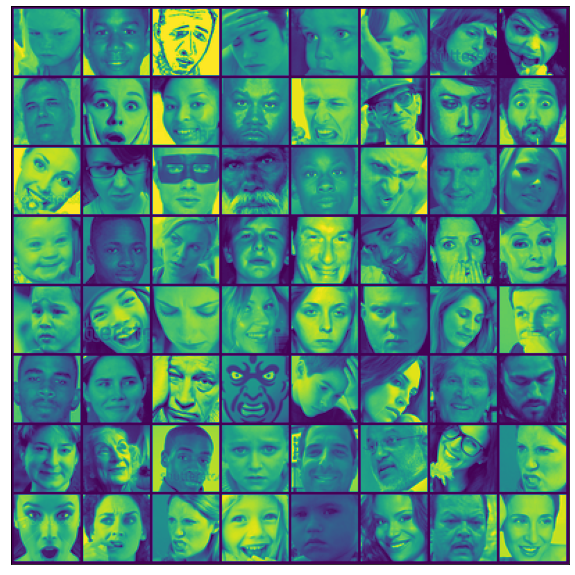

In [16]:
loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
images,labels = next(iter(loader))
grid = torchvision.utils.make_grid(images).permute((1,2,0))
displayImages(grid,labels)

In [ ]:
loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=True)
network = Network()
network = network.to(device)
optimizer = optim.Adam(network.parameters(),lr=0.0001,weight_decay = 0.0000001)
min_loss = 100000
train_accuracy_array=[]
val_accuracy_array=[]
for a in tqdm_notebook(range(50)):
  correct_preds=0
  
  for batch in tqdm_notebook(loader):
    images,labels = batch
    images,labels = images.to(device,dtype=torch.float),labels.to(device)
    optimizer.zero_grad()
    output = network(images)
    loss = F.cross_entropy(output,labels)
    loss.backward()
    optimizer.step()
    correct_preds+=accuracy(output,labels)
    
    del images,labels,output
    torch.cuda.empty_cache()
    if(loss.item()<min_loss):
      min_loss = loss.item()
      best_model = copy.deepcopy(network.state_dict())
  train_accuracy_array.append(correct_preds/len(loader.dataset))
  network.eval()
  val_accuracy=0
  for batch in val_loader:
    images,labels = batch
    images,labels = images.to(device,dtype=torch.float),labels.to(device)
    output = network(images)
    val_accuracy += accuracy(output,labels)
  val_accuracy_array.append(val_accuracy/len(val_loader.dataset))
  del images,labels,output
  torch.cuda.empty_cache()
  network.train()
  print("epoch is {} train accuracy is {} and val accuracy is {}".format(a,correct_preds/len(loader.dataset),val_accuracy/len(val_loader.dataset)))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

epoch is 0 train accuracy is 0.2568903208951975 and val accuracy is 0.33472657610588646


  0%|          | 0/359 [00:00<?, ?it/s]

epoch is 1 train accuracy is 0.3599512343797623 and val accuracy is 0.4171020550330895


  0%|          | 0/359 [00:00<?, ?it/s]

In [ ]:
plt.plot(range(50),train_accuracy_array)
plt.plot(range(50),val_accuracy_array)
plt.legend(["Train Accuracy","Test Accuracy"],loc=4)

In [ ]:
network.load_state_dict(best_model)
network.eval()

In [ ]:
preds = []
true = []
for (images,labels) in val_loader:
    images,labels = images.to(device),labels.to(device)
    output = network(images)
    preds.extend(torch.argmax(F.softmax(output),axis=1).cpu().numpy())
    true.extend(labels.cpu().numpy())

In [ ]:
matrix = confusion_matrix(true,preds)

In [ ]:
sns.heatmap(matrix,annot=True,fmt='g',xticklabels=classes,yticklabels=classes)

In [ ]:
loader = torch.utils.data.DataLoader(train_dataset,batch_size=1)
onnx_model_path = "model.onnx"
images,labels = next(iter(loader))
torch.onnx.export(network.to(device),images.to(device).float(),onnx_model_path,verbose=True)